In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset = pd.read_csv("All Users Combined.csv")
dataset.head()

,AG-X,AG-Y,AG-Z,Acc-X,Acc-Y,Acc-Z,Gravity-X,Gravity-Y,Gravity-Z,RR-X,RR-Y,RR-Z,RV-X,RV-Y,RV-Z,cos,activity
0,-9.494311,5.423363,0.196757,-1.684995,0.401508,1.334339,-8.855526,4.199663,-0.335983,-0.762366,-0.750471,1.109060,0.232662,0.672025,0.101603,0.695649,Running
1,-8.890651,2.520043,0.963310,-0.895032,-1.936677,1.436671,-8.399648,5.060810,0.067106,-0.613229,-0.121966,1.906942,0.245168,0.660660,0.131849,0.697164,Running
2,-5.632800,1.581015,0.230293,2.350318,-3.642859,-1.169414,-7.911231,5.790931,0.218930,-0.142383,-0.352063,1.759936,0.264845,0.648175,0.163016,0.695091,Running
3,-6.322698,6.228244,-0.756644,0.812825,-0.722664,-0.334024,-7.523226,6.280006,0.364660,-0.148775,-0.382955,1.208129,0.299550,0.624335,0.195080,0.694564,Running
4,-7.640211,4.862821,1.715490,0.349670,-0.468074,-0.378780,-6.921238,6.909286,0.727059,-1.047857,0.379773,0.828895,0.310003,0.607825,0.220415,0.697039,Running


In [3]:
!pip install pyts

from pyts.image import GramianAngularField


DATASET PREPROCESSING START


In [4]:
X = dataset.drop('activity', axis=1)
y = dataset.select_dtypes(include=[object])

In [5]:
y.activity.unique()

array(['Running', 'Sitting', 'Standing', 'Walking', 'downstaires',
       'upstaires'], dtype=object)

In [6]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

y = y.apply(le.fit_transform)
y.head()

,activity
0,0
1,0
2,0
3,0
4,0


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,random_state=42)

In [8]:
import pandas as pd

# Assuming y is a pandas DataFrame or Series and activity is a column in y
value_counts = y['activity'].value_counts()
print(value_counts)


activity
3    25371
1    19784
0    14997
2    14795
5    10764
4     8487
Name: count, dtype: int64


In [9]:
from sklearn.utils import resample

# Combine your features and target into one DataFrame
data = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
min_class = data['activity'].value_counts().idxmin()
min_count = data['activity'].value_counts().min()

balanced_data = pd.DataFrame()

for activity in data['activity'].unique():
    activity_data = data[data['activity'] == activity]
    activity_data_balanced = resample(activity_data, 
                                      replace=False,    # sample without replacement
                                      n_samples=min_count,     # match the minority n
                                      random_state=42)  # reproducible results
    balanced_data = pd.concat([balanced_data, activity_data_balanced])

# Separate the features and target again
X_train_balanced = balanced_data.drop('activity', axis=1)
y_train_balanced = balanced_data['activity']


In [10]:
value_counts=balanced_data['activity'].value_counts()
print(value_counts)

activity
2    6737
1    6737
3    6737
0    6737
4    6737
5    6737
Name: count, dtype: int64


In [11]:
X_train_balanced.shape

(40422, 16)

In [12]:
y_train_balanced.shape

(40422,)

In [13]:
#not a part of dataset prepocessing
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, MaxPooling2D, Dropout, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from sklearn.metrics import f1_score

# Define precision metric
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Define recall metric
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Define f1 score metric
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Load and preprocess your data
# Assuming x_train, y_train, x_test, y_test are your data and labels


In [14]:
gaf = GramianAngularField()

In [15]:
x_train = gaf.fit_transform(X_train_balanced)
x_test= gaf.fit_transform(X_test)

In [16]:
x_train.shape

(40422, 16, 16)

In [17]:
# Check unique labels
unique_labels_train = np.unique(y_train)
unique_labels_test = np.unique(y_test)
print("Unique labels in y_train:", unique_labels_train)
print("Unique labels in y_test:", unique_labels_test)

# Find the maximum label value
max_label_value = max(unique_labels_train.max(), unique_labels_test.max())
print("Max label value:", max_label_value)

# Set num_classes to the maximum label value plus one
num_classes = int(max_label_value + 1)
print("Number of classes:", num_classes)

# One-hot encode the target labels
y_train_one_hot = to_categorical(y_train_balanced, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

print("Shape of y_train_one_hot:", y_train_one_hot.shape)
print("Shape of y_test_one_hot:", y_test_one_hot.shape)


Unique labels in y_train: [0 1 2 3 4 5]
Unique labels in y_test: [0 1 2 3 4 5]
Max label value: 5
Number of classes: 6
Shape of y_train_one_hot: (40422, 6)
Shape of y_test_one_hot: (18840, 6)


In [18]:
y_train.shape


(75358, 1)

In [19]:
x_train.shape

(40422, 16, 16)

In [20]:
x_train = x_train.reshape(x_train.shape[0], 16, 16, 1)
x_train = x_train.astype('float32')


In [ ]:
DATASET PREPROCESSING END

MODEL ARCHITECTURE

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, GlobalMaxPooling2D, Dense

# Define the input shape of the data
input_shape = (16, 16, 1)


num_classes = 6 

# Build the model
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    GlobalMaxPooling2D(),

    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')  # Number of classes
])

# Print the model summary
model.summary()


C:\Users\agnis\Downloads\agnish\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 16, 16, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 329,670 (1.26 MB)

 Trainable params: 328,902 (1.25 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
MODEL TRAI

In [22]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', precision_m, recall_m, f1_m])


In [23]:
history=model.fit(x_train, y_train_one_hot,
          validation_data=(x_test, y_test_one_hot),
          epochs=30,
          batch_size=64)

Epoch 1/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 76s 110ms/step - accuracy: 0.5623 - f1_m: 0.5276 - loss: 1.2418 - precision_m: 0.6697 - recall_m: 0.4396 - val_accuracy: 0.7363 - val_f1_m: 0.6635 - val_loss: 0.7794 - val_precision_m: 0.8282 - val_recall_m: 0.5550
Epoch 2/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 66s 105ms/step - accuracy: 0.7684 - f1_m: 0.7619 - loss: 0.6111 - precision_m: 0.8389 - recall_m: 0.6989 - val_accuracy: 0.8448 - val_f1_m: 0.8409 - val_loss: 0.4376 - val_precision_m: 0.9038 - val_recall_m: 0.7870
Epoch 3/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 68s 107ms/step - accuracy: 0.8125 - f1_m: 0.8095 - loss: 0.5050 - precision_m: 0.8655 - recall_m: 0.7611 - val_accuracy: 0.8592 - val_f1_m: 0.8561 - val_loss: 0.3864 - val_precision_m: 0.9147 - val_recall_m: 0.8052
Epoch 4/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 67s 106ms/step - accuracy: 0.8365 - f1_m: 0.8343 - loss: 0.4451 - precision_m: 0.8836 - recall_m: 0.7909 - val_accuracy: 0.8844 - val_f1_m: 0.8796 - val_loss: 0.3355 - val_precision_m: 0.9368 - v

In [24]:
# Predict on the test set
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

# Calculate the weighted F1 score
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
print("Weighted F1 Score:", weighted_f1)

589/589 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step
Weighted F1 Score: 0.9266105767578404


In [25]:
model.save('model_HAR.h5')

In [26]:
model.save('my_model.keras')

In [27]:
from tensorflow.keras.models import load_model

# Load the model from the .h5 file
model_HAR_loaded = load_model('model_HAR.h5', custom_objects={'f1_m': f1_m, 'precision_m': precision_m, 'recall_m': recall_m})

# Print the summary of the loaded model to verify
model_HAR_loaded.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 16, 16, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 329,672 (1.26 MB)

 Trainable params: 328,902 (1.25 MB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 2 (12.00 B)

In [28]:
import json

# Convert the NumPy arrays to lists
history_dict = {key: [float(val) for val in values] for key, values in history.history.items()}

# Save the history as JSON
with open('model_history.json', 'w') as f:
    json.dump(history_dict, f)

In [29]:
import json

# Load the history from the JSON file
with open('model_history.json', 'r') as f:
    history = json.load(f)

# Optionally, convert lists back to NumPy arrays (if needed)
import numpy as np
history = {key: np.array(values) for key, values in history.items()}

# Now you can use the history dictionary
print(history)

{'accuracy': array([0.65773588, 0.77878386, 0.81341845, 0.83739054, 0.85052693,
       0.85809708, 0.86678046, 0.87363315, 0.87694818, 0.88459253,
       0.88798177, 0.89310277, 0.89498293, 0.90094501, 0.90200883,
       0.90636289, 0.90866357, 0.91061801, 0.91326505, 0.9119786 ,
       0.91677797, 0.91870761, 0.91917765, 0.920192  , 0.92157733,
       0.92650044, 0.92615408, 0.9263767 , 0.92951858, 0.93184406]), 'f1_m': array([0.63214874, 0.77265626, 0.81098086, 0.834714  , 0.84916455,
       0.8574658 , 0.86656326, 0.87256747, 0.8768515 , 0.88310891,
       0.88790834, 0.89367384, 0.89452815, 0.90073627, 0.9018681 ,
       0.90651923, 0.9093377 , 0.91023999, 0.91256416, 0.91165936,
       0.9170447 , 0.91888118, 0.918706  , 0.92032766, 0.92155164,
       0.92596406, 0.92618138, 0.92655492, 0.9289397 , 0.93239427]), 'loss': array([0.89620608, 0.58743685, 0.50149071, 0.445364  , 0.41352046,
       0.38650933, 0.36541864, 0.3492389 , 0.33447793, 0.32262203,
       0.30878133, 0.29340494

589/589 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step
Confusion Matrix (in percentages):
[[9.087e+01 0.000e+00 1.000e-01 2.530e+00 3.740e+00 2.760e+00]
 [0.000e+00 9.990e+01 3.000e-02 0.000e+00 5.000e-02 3.000e-02]
 [3.000e-02 7.000e-02 9.933e+01 1.000e-01 2.700e-01 2.000e-01]
 [1.690e+00 2.000e-02 1.600e-01 9.068e+01 3.640e+00 3.820e+00]
 [2.690e+00 2.300e-01 6.300e-01 5.540e+00 8.189e+01 9.030e+00]
 [3.420e+00 5.000e-02 4.300e-01 5.270e+00 5.750e+00 8.509e+01]]
Overall Accuracy: 92.60%


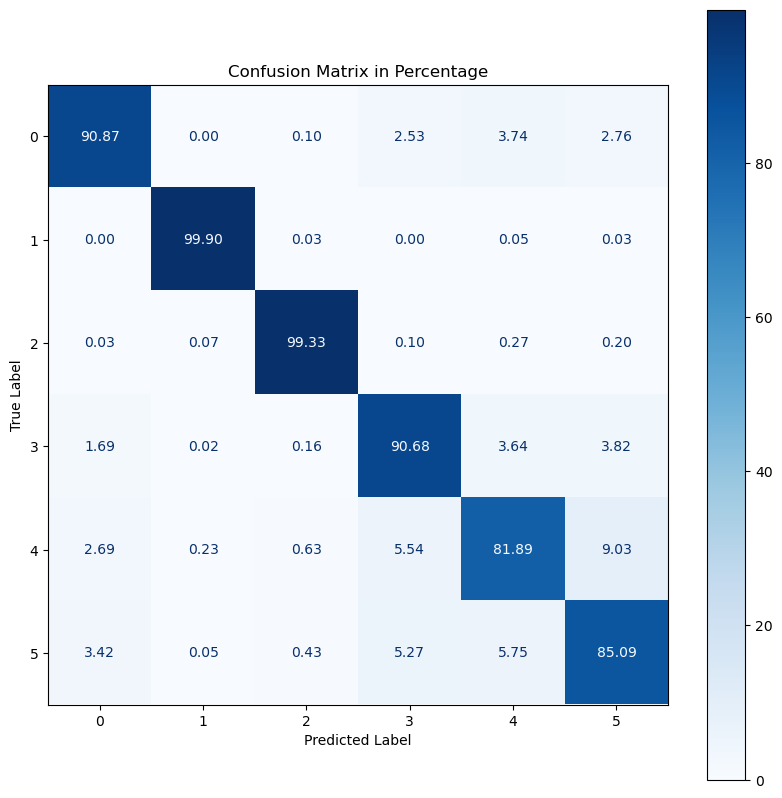

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming model_CNN is already trained and x_test, y_test_one_hot are available

# Predict the labels for the test set
y_pred = model_HAR_loaded.predict(x_test)

# Convert one-hot encoded labels to class labels
y_test_labels = y_test_one_hot.argmax(axis=1)
y_pred_labels = y_pred.argmax(axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Calculate overall accuracy
accuracy = np.trace(cm) / np.sum(cm)

# Normalize the confusion matrix by row (true classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Convert to percentages
cm_percent = cm_normalized * 100

# Print the confusion matrix in percentages
print("Confusion Matrix (in percentages):")
print(np.around(cm_percent, decimals=2))

# Print overall accuracy
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=np.unique(y_test_labels))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")
plt.title('Confusion Matrix in Percentage')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)
plt.show()


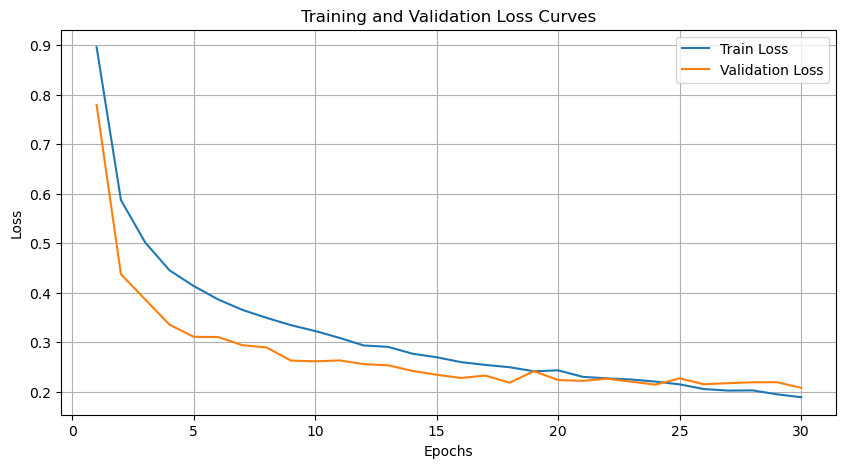

In [31]:
# Extract training and validation loss from history
train_losses = history['loss']
val_losses = history['val_loss']
epochs = range(1, len(train_losses) + 1)

# Plotting train and test loss curves
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


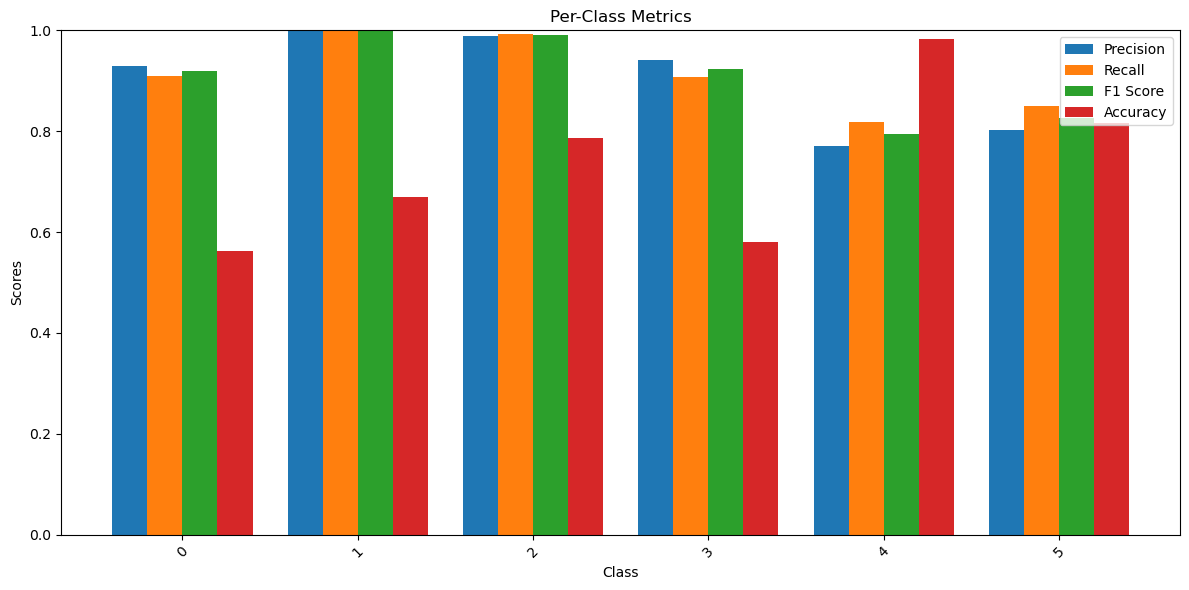

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report



# Ensure class_names contains the correct unique classes
class_names = np.unique(np.concatenate((y_test_labels, y_pred_labels)))

# Compute classification report
report = classification_report(y_test_labels, y_pred_labels, target_names=class_names, output_dict=True)

# Extract metrics for each class
per_class_precision = [report[class_name]['precision'] for class_name in class_names]
per_class_recall = [report[class_name]['recall'] for class_name in class_names]
per_class_f1 = [report[class_name]['f1-score'] for class_name in class_names]

# Example calculation of per-class accuracy (replace with your actual calculation)
per_class_accuracy = np.random.rand(len(class_names))  # Replace with actual accuracy calculation

# Plotting per-class metrics
plt.figure(figsize=(12, 6))

bar_width = 0.2
index = np.arange(len(class_names))

plt.bar(index - 1.5 * bar_width, per_class_precision, width=bar_width, label='Precision')
plt.bar(index - 0.5 * bar_width, per_class_recall, width=bar_width, label='Recall')
plt.bar(index + 0.5 * bar_width, per_class_f1, width=bar_width, label='F1 Score')
plt.bar(index + 1.5 * bar_width, per_class_accuracy, width=bar_width, label='Accuracy')

plt.xlabel('Class')
plt.ylabel('Scores')
plt.title('Per-Class Metrics')
plt.xticks(index, class_names, rotation=45)
plt.ylim(0, 1)  # Assuming accuracy ranges from 0 to 1
plt.legend()
plt.tight_layout()
plt.show()
